<a href="https://colab.research.google.com/github/ctrl-liuxiaohu/-/blob/master/Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# coding: utf-8

import sys
from collections import Counter
import numpy as np
import tensorflow.keras as kr
import os

if sys.version_info[0] > 2:
    is_py3 = True
else:
    reload(sys)
    sys.setdefaultencoding("utf-8")
    is_py3 = False

def open_file(filename, mode='r'):
    """
    常用文件操作，可在python2和python3间切换.
    mode: 'r' or 'w' for read or write
    """
    if is_py3:
        return open(filename, mode, encoding='utf-8', errors='ignore')
    else:
        return open(filename, mode)

def read_file(filename):
    """读取单个文件，文件中包含多个类别"""
    contents = []
    labels = []
    with open_file(filename) as f:
        for line in f:
            try:
                raw = line.strip().split("\t")
                content = raw[1].split(' ')
                if content:
                    contents.append(content)
                    labels.append(raw[0])
            except:
                pass
    return contents, labels    

def read_single_file(filename):
    """读取单个文件，文件为单一类别"""
    contents = []
    label = filename.split('/')[-1].split('.')[0]
    with open_file(filename) as f:
        for line in f:
            try:
                content = line.strip().split(' ')
                if content:
                    contents.append(content)
            except:
                pass
    return contents, label

def read_files(dirname):
    """读取文件夹"""
    contents = []
    labels = []
    files = [f for f in os.listdir(dirname) if f.endswith(".txt")]
    for filename in files:
        content, label = read_single_file(os.path.join(dirname, filename))
        contents.extend(content)
        labels.extend([label]*len(content))
    return contents, labels

def build_vocab(train_dir, vocab_file, vocab_size=5000):
    """根据训练集构建词汇表，存储"""
    data_train, _ = read_files(train_dir)

    all_data = []
    for content in data_train:
        all_data.extend(content)

    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    open_file(vocab_file, mode='w').write('\n'.join(words) + '\n')


def read_vocab(vocab_file):
    """读取词汇表"""
    # words = open_file(vocab_dir).read().strip().split('\n')
    with open_file(vocab_file) as fp:
        # 如果是py2 则每个值都转化为unicode
        words = [_.strip() for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id


def read_category():
    """读取分类，编码"""
    categories = ['1', '2', '3', '4', '5','6']
    cat_to_id = dict(zip(categories, range(len(categories))))
    return categories, cat_to_id

def encode_cate(content, words):
    """将id表示的内容转换为文字"""
    return [(words[x] if x in words else 40000) for x in content]

def encode_sentences(contents, words):
    """将id表示的内容转换为文字"""
    return [encode_cate(x,words) for x in contents]

def process_file(filename, word_to_id, cat_to_id, max_length=600):
    """将文件转换为id表示"""
    contents, labels = read_file(filename)

    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word_to_id[x] for x in contents[i] if x in word_to_id])
        label_id.append(cat_to_id[labels[i]])

    # 使用keras提供的pad_sequences来将文本pad为固定长度
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length)
    y_pad = kr.utils.to_categorical(label_id, num_classes=len(cat_to_id))  # 将标签转换为one-hot表示

    return x_pad, y_pad


def batch_iter(x, y, batch_size=64):
    """生成批次数据"""
    data_len = len(x)
    num_batch = int((data_len - 1) / batch_size) + 1

    indices = np.random.permutation(np.arange(data_len))
    x_shuffle = x[indices]
    y_shuffle = y[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_shuffle[start_id:end_id], y_shuffle[start_id:end_id]


In [0]:
import jieba

In [0]:
import pandas as pd
import re
df_train = pd.read_csv('data_user_portaits/train.csv',sep="###__###",engine='python',names =('ID', 'Age', 'Gender', 'Education', 'Query_List'))
df_train.shape

(9629, 5)

In [0]:
df_train.shape

(9629, 2)

In [0]:
df_train["Age"].unique()

array([1, 2, 4, 3, 6, 5, 0])

In [0]:
df_train=df_train.loc[:,['Age','Query_List']]
df_train["Query_List"] = df_train['Query_List'].apply(lambda x:re.sub("\t","",x))
df_train.head()

,Age,Query_List
0,1,柔和双沟女生中财网首页 财经http://pan.baidu.com/s/1plpjtn9周...
1,2,"广州厨宝烤箱世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕厦门酒店用品批发市场我只是不想让你支..."
2,4,钻石之泪耳机盘锦到沈阳旅顺公交辽宁阜新车牌baiduk715k716盘锦到台安网游之永生网游...
3,4,最受欢迎狗狗排行榜舶怎么读场景描 写范例三维绘图软件枣和酸奶能一起吃吗好不壮观租衣服的网站动...
4,2,干槽症能自愈吗太太万岁叶舒心去没去美国干槽症右眼皮下面一直跳是怎么回事麦当劳麦旋风的勺子吉林...


In [0]:
age_1=df_train.loc[df_train['Age']==1,:]
age_1.shape

(3775, 2)

In [0]:
age_2=df_train.loc[df_train['Age']==2,:]
age_3=df_train.loc[df_train['Age']==3,:]
age_4=df_train.loc[df_train['Age']==4,:]
age_5=df_train.loc[df_train['Age']==5,:]
age_6=df_train.loc[df_train['Age']==6,:]


,Age,Query_List
7,6,昂的笔顺三年级上册数学口算牛的英语怎么读抓木机60米差不多跑多长时间似乎造句可可小爱起动保护...
15,6,吴靖平使用假征值税发票属什么行为抽到81签的解释奔驰车轿车为什么不是大标志图购车后没有取得任...
141,6,白银连环杀人案图片qq影音字幕另存为hermine台风前列腺快感布兰丁斯城堡一共几季包旭威英...
231,6,五牙直播元彪逆战刀战平砍处女男喜欢一个人的表现夏佐解说逆战刀战视频逆战艾米莉亚手机壁纸爱拍逆...
293,6,西普大陆终极蜘蛛侠网络测速朱碧石精灵宝可梦xyz最新vivoxplay5旗舰版圣斗士混沌篇月...


In [0]:
print("age_1.shape:",age_1.shape)
print("age_2.shape:",age_2.shape)
print("age_3.shape:",age_3.shape)
print("age_4.shape:",age_4.shape)
print("age_5.shape:",age_5.shape)
print("age_6.shape:",age_6.shape)


age_1.shape: (3775, 2)
age_2.shape: (2597, 2)
age_3.shape: (1748, 2)
age_4.shape: (996, 2)
age_5.shape: (301, 2)
age_6.shape: (44, 2)


In [0]:
#去停用词和分词
stopwords = ['的', '呀', '这', '那', '就', '的话', '如果']
def seg_sentence(sentence,stopwords):
    sentence_seged=jieba.cut(sentence)
    outstr=''
    for word in sentence_seged:
        if word not in stopwords:
            outstr+=word
            outstr+=" "
    return outstr


In [0]:
age_6["Query_List"]=age_6["Query_List"].apply(lambda x: seg_sentence(x,stopwords)).dropna()
age_6['Query_List'].to_csv('data_user_portaits/age/6.txt',sep='\t',index=False,header=None)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
#查看保存的txt文件时候符合要求
f = open("data_user_portaits/age/5.txt","r")   #设置文件对象
for i in range(5):
    print(f.readline().strip())

In [0]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout
#class_num和last_activation两个属性不需要在传入
class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=6,
                 last_activation='softmax'):
        #文本中句子的最大长度
        self.maxlen = maxlen
        #文本最多的特征值
        self.max_features = max_features
        #词向量的维度
        self.embedding_dims = embedding_dims
        #分成几类
        self.class_num = class_num
        #最后的激活函数
        self.last_activation = last_activation

    def get_model(self):
        #卷积核的size采用的是3,4，5，类似于n-gram，分别表示考虑3,4,5个词之间的相关性。
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        #卷积一次，池化一次，将池化后的结果存放在列表，最终列表全部元素进行一次全连接。
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
            #这里会把经过池化层得到的3个128维的向量按照轴拼接起来，变成384维向量。
        x = Concatenate()(convs)
        #全连接层，通过线性加权和设置偏置量，最后经过激活函数输出成为分类结果。
        output = Dense(self.class_num, activation=self.last_activation)(x)
        
        model = Model(inputs=input, outputs=output)
        return model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import sys
#sys.path.append('../data/lesson2_data')
sys.path.append('drive/My Drive/age')

# 路径等配置
data_dir = "drive/My Drive/age"
#data_dir = "data/lesson2_data/data"
vocab_file = "drive/My Drive/vocab/vocab.txt"
vocab_size = 40000

# 神经网络配置
max_features = 40001
maxlen = 100
batch_size = 128
embedding_dims = 50
epochs = 16

print('数据预处理与加载数据...')
# 如果不存在词汇表，重建
if not os.path.exists(vocab_file): 
    #build_vocab是utils中的函数
    build_vocab(data_dir, vocab_file, vocab_size)
#read_category，read_vocab：utils中中的函数，获得 词汇/类别 与id映射字典
categories, cat_to_id = read_category()
print("categories:",categories)
print("cat_to_id:",cat_to_id)

words, word_to_id = read_vocab(vocab_file)

# 全部数据
#util模块的函数
x, y = read_files(data_dir)

data = list(zip(x,y))
print(y[0:2])
#del x,y
# 乱序
random.shuffle(data)

print("data[1:3]",data[1:3])




数据预处理与加载数据...
categories: ['1', '2', '3', '4', '5', '6']
cat_to_id: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
['6', '6']
data[1:3] [(['紫', '玛瑙', '珠有', '需要', '挂件', '和', '手', '玩', '(', '把件', ')', ',', '玛瑙', '(', '扳指', ',', '戒指', ',', '手', '台湾', '碧玉', '白玉', '髓', '止疼', '挂', '一些', '什么', '水', '黄蜡', '石', '价格', '头花', '蓼', '功效', '与', '作用', '阿拉善', '原石', '玛瑙', '蓝', '沙石', '金', '砂石', '108', '手链', '价格', 'vivo', '手机', '横屏', '没', '问题', ',', '竖屏', '有', '一点', '失灵', '圆通', '快递', '查询', '单号', '张如剑', '裸花', '紫珠', '住院病人', '盐水', '中加', '什么', '可以', '止疼', 'vivo', '手机', '横屏', '竖屏', '切换', '水草', '玛瑙', '头花', '蓼', '头花', '蓼', '禁忌', '紫', '沙石', '阿拉善', '玛瑙', '金镶玉', '手链', '价格', '苹果', '6s', '屏幕', '多大', '尺寸', '黄龙', '玉', '手把', '件', '图片', '盐水', '中加', '什么', '可以', '止疼', '尿', '红细胞', '黑曜石', '挂', '坠', '新疆', '金丝', '玉', '好坏', '鉴别', '新疆', '三彩玉', '价格', '水', '胆石', '手把', '件', '碧玉', '养殖', '方法', '和', '注意事项', '紫绿', '玛瑙', '黄龙', '玉', '紫砂', '石', '禁忌', '楼兰', '玉金', '砂石', '手链', '价格', '金', '砂石', '手机', '流量', '流失', '手机', '竖屏', '有', '一段', '滑', 

In [0]:
print("words:",words)
print("word_to_id:",word_to_id)

words: ['<PAD>', '', '什么', '是', '怎么', '吗', '图片', '有', '了', '和', '我', '在', '多少', '手机', '意思', ',', '小说', '视频', '之', '到', '可以', '好', '2016', '下载', '大全', '吃', '你', '与', '用', '能', '不', '人', '电影', 'qq', '钱', '中国', '怎么办', '大', '说', '世界', '上', '哪个', '为什么', '年', '做', '小', '2', '重生', '如何', '很', '百度', '会', '英语', 'txt', '官网', '月', '电视剧', '后', '谁', '吧', '查询', '游戏', '被', '一个', '做法', '中', '哪里', '要', '倾城', '荣耀', '哪些', '怎么样', '苹果', '怀孕', '时间', '微微一笑', '大学', '号', '王者', '里', '软件', '版', '怎样', '3', '去', '电脑', '学院', '爱', '阅读', '字', '网', '漫画', '价格', '哪', '全集', '微信', '怎么回事', '在线', '成语', '英文', '北京', '时候', '免费', '多久', '作用', '宝宝', '新', '头像', '都', '英雄', '最', '系统', '穿越', '看', '快递', '对', '.', '歌词', '功效', '/', '汽车', '云', '直播', '照片', '作文', '?', '电话', '打', '原因', '方法', '1', '多', '区别', '招聘', '买', '一', '症状', '女', '还是', '梦见', '5', 'lol', '上海', '女生', '攻略', '全文', '来', '名字', '需要', '自己', '还', '不能', '歌曲', ':', '没有', '医院', '动漫', '少女', '男', '写', '路', '-', '4', '最新', '好看', '快', '图', '老', '手游', '叫', '华为', '关于', '职业', '歌', '读', '孕妇

In [0]:
# 切分训练集和测试集
train_data, test_data = train_test_split(data)
print("type of train_data:",type(train_data))
print("len of train_data:",len(train_data))
print("type of test_data:",type(test_data))
print("len of test_data:",len(test_data))
# 对x_train上切分后的词语进行词典映射，转为词典，注意种类不映射，映射出来是一个列表，
#，每一个索引下的元素中都包含和原始词语同样个数的数字。
x_train = encode_sentences([content[0] for content in train_data], word_to_id)
#word_to_id是一个词典，就是根据文本中的词语形成的字典。其结构为，词语：id(0-39999)
print('x_train的格式：',type(x_train))
print("x_train type:",type(x_train))
print("x_train[1:2]:",x_train[1:2])
print("len of x_train[1]:",len(x_train[1]))
print("len of x_train[2]:",len(x_train[2]))
#把训练集上的第二列内容转化为数字，然后转换为二进制类矩阵
y_train = to_categorical(encode_cate([content[1] for content in train_data], cat_to_id))
#to_categorical返回一个np.array
print(cat_to_id)
print("y_train的格式:",type(y_train))
print("y_train的shape:",y_train.shape)
print("y_train的[1]",y_train[1])
x_test = encode_sentences([content[0] for content in test_data], word_to_id)
print("x_test的格式:",type(x_test))
print("x_test的len:",len(x_test))
print(x_test[1])
y_test = to_categorical(encode_cate([content[1] for content in test_data], cat_to_id))
print("y_test的格式:",type(y_test))
print("y_test的shape:",y_test.shape)
print(y_test[1])
print('对序列做padding，保证是 samples*timestep 的维度')
#因为每个sequence中的word数量不一致，利用下列方法可以补全sequence中的维度，补齐到100维
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
print("x_train的格式:",type(x_train))

x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print("x_test的格式:",type(x_test))

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('构建模型...')
#这里的model实际上是CLASS的Model类，实例化一个Model的方法有两种，
#一种是采用API，即本处，另一种方法是继承的方法（super）。
model = TextCNN(maxlen, max_features, embedding_dims).get_model()
#调用Model中的compile方法（优化器，损失函数，衡量标准，）
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')

type of train_data: <class 'list'>
len of train_data: 73750
type of test_data: <class 'list'>
len of test_data: 24584
x_train的格式： <class 'list'>
x_train type: <class 'list'>
x_train[1:2]: [[38818, 40000, 17801, 820, 5123, 3, 2, 750, 368, 1014, 203, 250, 469, 36669, 90, 40000, 869, 3758, 6916, 5934, 5504, 1123, 3, 12, 37, 6900, 166, 12218, 15662, 1094, 81, 184, 313, 4, 1204, 3551, 73, 101, 354, 8, 820, 5123, 36, 40000, 11439, 10444, 5268, 8499, 13478, 24, 633, 203, 40000, 173, 36542, 7056, 3849, 5, 5666, 40000, 5601, 40000, 40000, 40000, 5688, 5266, 16862, 29, 17355, 40000, 5, 17301, 8, 10, 479, 25754, 3916, 11264, 15, 1442, 20387, 40000, 36669, 90, 97, 3233, 40000, 5934, 5504, 1123, 341, 40, 2253, 4686, 4177, 36542, 7056, 51, 455, 610, 1818, 733, 37, 20387, 5934, 5504, 1123, 2342, 13821, 148, 28, 6231, 5, 5314, 3, 9984, 5521, 20777, 37231, 3, 2, 3945, 76, 2961, 1683, 111, 36542, 7056, 12207, 40000, 2727, 40000, 977, 40000, 3, 723, 11, 40000, 213, 5097, 5, 12039, 1016, 2, 147, 21, 8256,

In [0]:
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

y_train shape: (73750, 6)
y_test shape: (24584, 6)


In [0]:
from time import sleep
from tqdm import tqdm


In [0]:
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('data_user_portaits/cnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test,y_test))



Epoch 1/16
577/577 [==============================] - ETA: 0s - loss: 1.2423 - accuracy: 0.4898
Epoch 00001: saving model to data_user_portaits/cnn_model.h5
577/577 [==============================] - 112s 194ms/step - loss: 1.2423 - accuracy: 0.4898 - val_loss: 1.1561 - val_accuracy: 0.5327
Epoch 2/16
577/577 [==============================] - ETA: 0s - loss: 1.0327 - accuracy: 0.6045
Epoch 00002: saving model to data_user_portaits/cnn_model.h5
577/577 [==============================] - 111s 192ms/step - loss: 1.0327 - accuracy: 0.6045 - val_loss: 1.1602 - val_accuracy: 0.5378
Epoch 3/16
576/577 [============================>.] - ETA: 0s - loss: 0.8021 - accuracy: 0.7110
Epoch 00003: saving model to data_user_portaits/cnn_model.h5
577/577 [==============================] - 110s 191ms/step - loss: 0.8016 - accuracy: 0.7111 - val_loss: 1.2799 - val_accuracy: 0.5189
Epoch 4/16
577/577 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.8387
Epoch 00004: saving model to

In [9]:
print('对测试集预测...')
result = model.predict(x_test)
print('type of result:',type(result))
print('shape of result:',result.shape)
print('result[1]:',result[1])

对测试集预测...
type of result: <class 'numpy.ndarray'>
shape of result: (24584, 6)
result[1]: [1.9543152e-04 8.9518267e-01 1.0216760e-01 2.6846502e-04 5.6710443e-04
 1.6187966e-03]


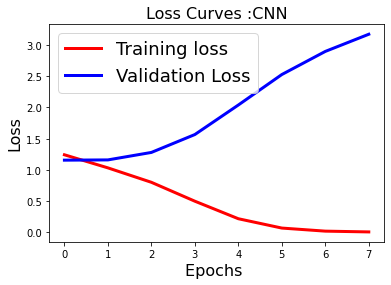

In [10]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('data_user_portaits/loss_cnn.png')
plt.show()

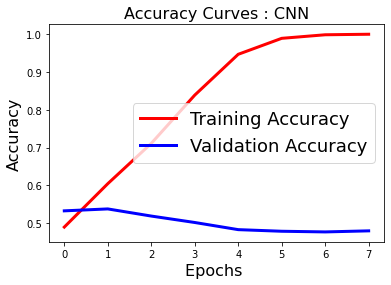

In [11]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('data_user_portaits/accuracy_cnn.png')
plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive')